In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import operator

In [2]:
project_path = '/home/ruben/Documents/GitHub/CrisisBureaucracy'
data_path = '/media/ruben/Elements/PhD/data/hansard'

In [4]:
# Load all sentences with 'bureaucracy' (not just annotated set, but everything: 4080 texts)
df = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/bureaucracy-sentences-full.tsv',sep='\t').dropna()

def load_full(id_):
    f = pd.read_csv(f'{data_path}/lemmatized_pm/uk.proc.d.{id_[:10]}.txt',sep='\t')
    return [list(f[f['id'] == 'uk.proc.d.' + id_]['text'])[0],list(f[f['id'] == 'uk.proc.d.' + id_]['text_lemmatized'])[0]]

    
df['text'] = [load_full("-".join(x.split('-')[1:-1]))[0] for x in tqdm(df['id'])]
df = df[['id','text']]

100%|██████████| 4080/4080 [02:02<00:00, 33.34it/s]


In [3]:
# Load a sample of 500 debates for TFIDF Vectorizer (> 400.000 speech-paragraphs)
sample_ = random.sample(gb(f'{data_path}/lemmatized_pm/*'),500)
sample_df = pd.DataFrame()

for s in tqdm(sample_):
    s = pd.read_csv(s,sep='\t')
    sample_df = sample_df.append(s)
sample_df = sample_df.dropna().reset_index(drop=True)

100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


In [5]:
# Reset metadata columns
sample_df['id'] = [sample_df['speech_member_ref'][c][5:] + '-' + x[10:] + "-" + sample_df['speech_member_party'][c].replace(' ','_').lower() for c,x in enumerate(sample_df['id'])]
sample_df = sample_df[['id','text_lemmatized']]
sample_df.columns = "id text".split(' ')
df = df.append(sample_df)
df = df.reset_index(drop=True)

In [6]:
# Split metadata to columns
df['year'] = [int(x.split('-')[1]) for x in df.id]
df['party'] = [str(x.split('-')[-1]) for x in df.id]
df['id'] = ["-".join(x.split('-')[1:-1]) for x in df.id]

In [7]:
# Preprocess text (remove stopwords, remove punctuation, lowercase)
df['text'] = utils.preprocess_(df['text'],stopwords=stopwords.words('english') + "hon member friend gentleman gentlemen speaker right".split(' '))

In [8]:
# Get Category Lexicons
lex_df = pd.read_csv(project_path + '/data/classifier/lexicon.csv')
lex_ = {c:[w for w in lex_df[c] if str(w) != 'nan'] for c in lex_df.columns}
vocab = list(set([item for sublist in list(lex_.values()) for item in sublist if str(item) != "nan"]))

In [9]:
# Create TFIDF Matrix with category lexicon as vocab
tfidf_vec = TfidfVectorizer(vocabulary=vocab,ngram_range=(1,3),max_df=0.5,min_df=0.01,smooth_idf=True)
mtrx = tfidf_vec.fit_transform(df.text)
dfm = pd.DataFrame.sparse.from_spmatrix(mtrx)
dfm.index = df.id 
dfm.columns = vocab

In [10]:
# Aggregate Clusters in Matrix
dfm_ = pd.DataFrame()

for k,v in lex_.items():
    dfm_[k] = dfm[v].sum(axis=1) # summing the tfidf scores per category
dfm_['year'] = [int(x.split('-')[0]) for x in dfm_.index]
dfmd = dfm_.groupby('year').sum().T

# # Normalise per Year and transform to rolling window
for c in list(dfmd.columns):
    dfmd[c] = dfmd[c] / dfmd[c].sum()
dfmd = dfmd.T.reset_index()

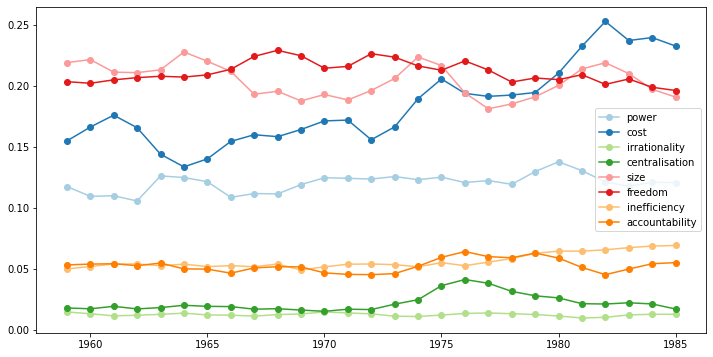

In [11]:
## Create plot with averages / year

data = dfm_
fig, ax = plt.subplots(figsize=(12,6))
for c,cl in enumerate("power cost irrationality centralisation size freedom inefficiency accountability".split(' ')):
    # plt.scatter(x=data['year'],y=data[cl],alpha=.1) for scatterplots, not necessary
    avgs = pd.DataFrame([[m,data[data['year'] == m][cl].sum() / len(data[data['year'] == m])] for m in set(data['year'])],columns=['year',cl]).sort_values('year')
    rm = avgs[cl].rolling(3, win_type='gaussian').mean(std=2)
    plt.plot(avgs['year'],rm,label=cl,marker='o',c=sns.color_palette('Paired',9)[c])
plt.legend()

In [12]:
d = dfm_.reset_index()
d['party'] =  df['party']

power


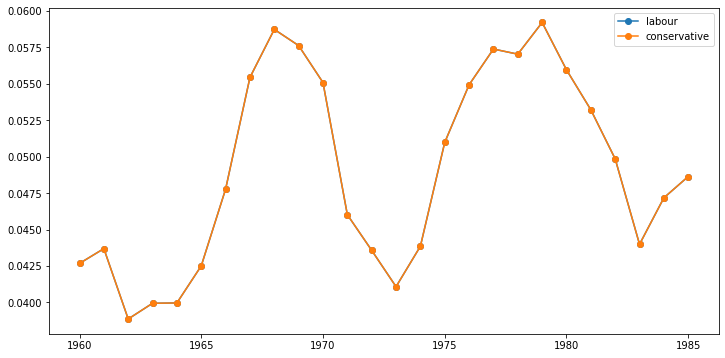

cost


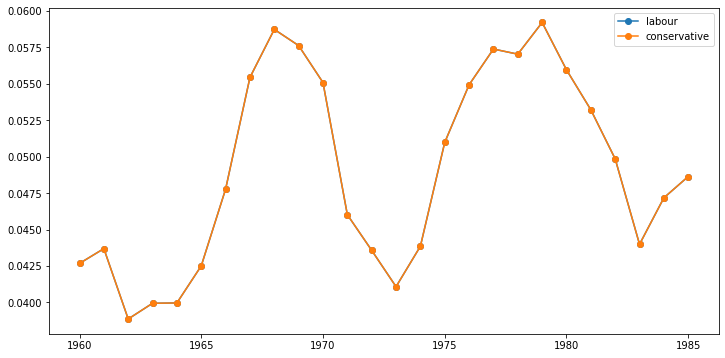

irrationality


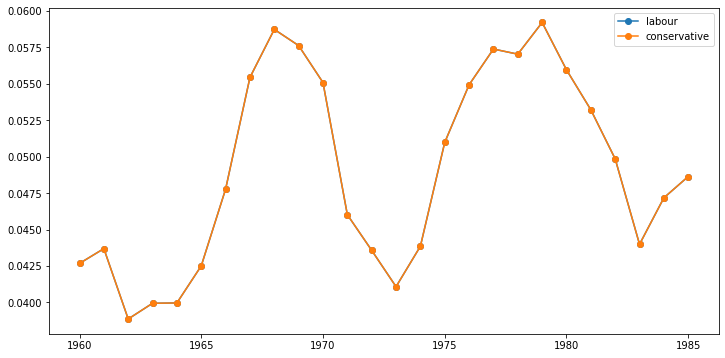

centralisation


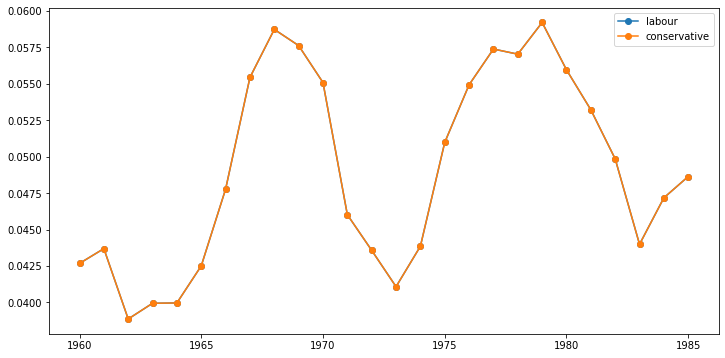

size


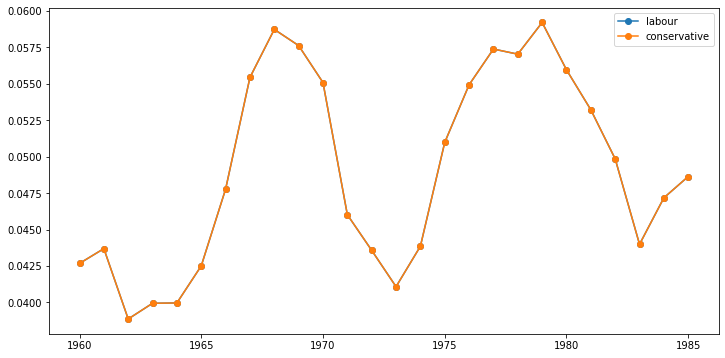

freedom


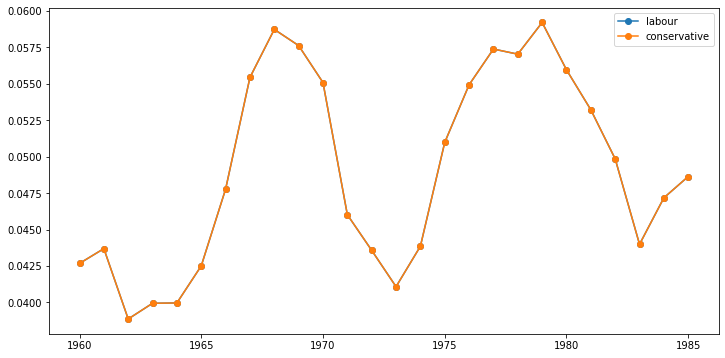

inefficiency


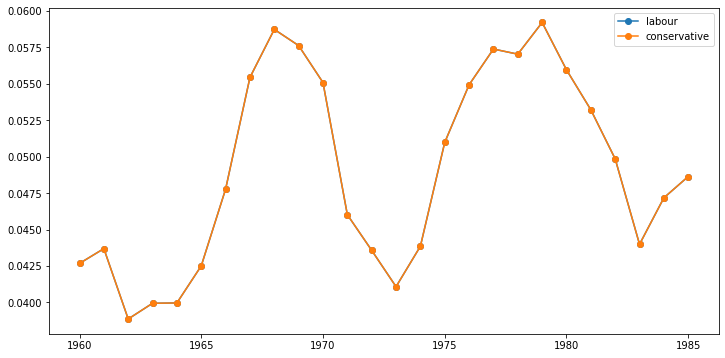

accountability


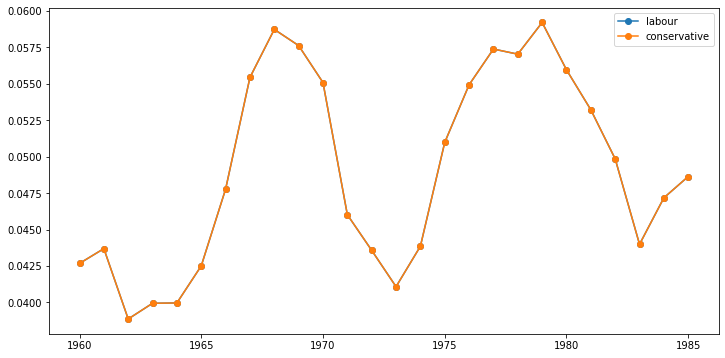

In [40]:
# Plot average argument score per category per party

for cl in "power cost irrationality centralisation size freedom inefficiency accountability".split(' '):
    print(cl)
    fig, ax = plt.subplots(figsize=(12,6))
    for p in ["labour","conservative"]:
        data = d[d['party'] == p]
        avgs = pd.DataFrame([[m,data[data['year'] == m][cl].sum() / len(data[data['year'] == m])] for m in set(data['year'])],columns=['year',cl]).sort_values('year')
        # rm = avgs[cl].rolling(4, win_type='gaussian').mean(std=3)
        plt.plot(avgs['year'],rm,label=p,marker='o')
    plt.legend()
    plt.show()
    plt.close()

In [33]:
stdf = []

for c,i in dfm_.iterrows():
    i = i.to_dict()
    i = {k:v for k,v in i.items() if k != 'year'}
    i = dict(sorted(i.items(), key=operator.itemgetter(1), reverse=True)[:2])
    i = list(i.keys())
    stdf.append([i[0],i[1]])

In [35]:
stdf_ = pd.DataFrame(stdf,columns=['s','t'])
stdf_['n'] = 1
stdf_ = stdf_.groupby(['s','t']).sum().reset_index().pivot(index='s',columns='t',values='n')

In [38]:
d = stdf_.fillna(0)

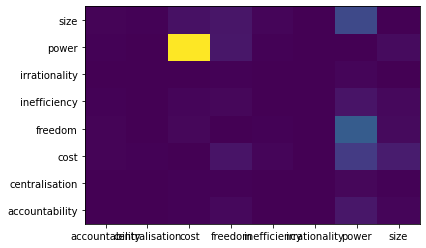

In [39]:
plt.pcolor(d)
plt.yticks(np.arange(0.5, len(d.index), 1), d.index)
plt.xticks(np.arange(0.5, len(d.columns), 1), d.columns)
plt.show()

<AxesSubplot:xlabel='t', ylabel='s'>

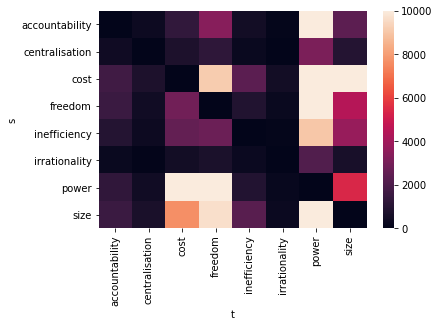

In [43]:
sns.heatmap(d,vmax=10000)